In [11]:
import pandas as pd
import os, time,json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tqdm.notebook import tqdm_notebook

In [2]:
with open('/Users/gleal/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()

dict_keys(['api-key'])

In [3]:
import tmdbsimple as tmdb
tmdb.API_KEY =  login['api-key']

In [13]:
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['.ipynb_checkpoints',
 'final_tmdbdata2000.csv.gz',
 'final_tmdbdata2001.csv.gz',
 'title_akas.csv.gz',
 'title_basics.csv.gz',
 'title_ratings.csv.gz',
 'tmdb_apiresults2000.json',
 'tmdb_apiresults2001.json',
 'tmdb_results_combined.csv.gz']

In [4]:
def get_movie_with_rating(movie_id):
    # Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    # save the .info .releases dictionaries
    movie_info = movie.info()

    releases = movie.releases()
    # Loop through countries in releases
    for c in releases['countries']:
        # if the country abbreviation==US
        if c['iso_3166_1' ] =='US':
            ## save a "certification" key in the info dict with the certification
            movie_info['certification'] = c['certification']
    return movie_info

In [5]:
def write_json(new_data, filename): 
    """Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""

    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [7]:
basics = pd.read_csv("Data/title_basics.csv.gz", low_memory = False)
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0068865,movie,Lives of Performers,Lives of Performers,0,2016.0,NaN,90,Drama
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
4,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"


### Because of the example hypothesis i chose I will use years 2018 and 2020

In [8]:
YEARS_TO_GET = [2018,2020]

In [9]:
errors = [ ]

In [14]:
for YEAR in tqdm_notebook(YEARS_TO_GET,desc='YEARS',
                          position=0):
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_apiresults{YEAR}.json'

    # Check if file exists
    file_exists = os.path.isfile(JSON_FILE)


    # If it does not exist: create it
    if file_exists == False:
    # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)



    #Saving new year as the current df
    df = basics.loc[ basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()#.to_list()


    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)


    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]


    #Get index and movie id from list
    # INNER Loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        # Attempt to retrieve then data for the movie id
        try:
            temp = get_movie_with_rating(movie_id)  #This uses your pre-made function
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)

        # If it fails,  make a dict with just the id and None for certification.
        except Exception as e:
            errors.append([movie_id, e])


    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdbdata{YEAR}.csv.gz", compression="gzip", index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2018:   0%|          | 0/5786 [00:00<?, ?it/s]

Movies from 2020:   0%|          | 0/5010 [00:00<?, ?it/s]

In [19]:
import glob
q = "Data/final_tmdbdata*.csv.gz"
year_files = sorted(glob.glob(q))
year_files

['Data\\final_tmdbdata2000.csv.gz',
 'Data\\final_tmdbdata2001.csv.gz',
 'Data\\final_tmdbdata2018.csv.gz',
 'Data\\final_tmdbdata2020.csv.gz']

In [20]:
## Loading and Concatenating the list of dfs with 1 line
df_combined = pd.concat([pd.read_csv(file, index_col=0) for file in year_files])

In [21]:
## Saving the final combined dataframe
final_fname ='Data/final_tmdb_combined.csv.gz'
df_combined.to_csv(final_fname, compression='gzip', index=False)

In [22]:
df_combined = pd.read_csv(final_fname)
df_combined.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.50,22.0,NaN
2,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.45,10.0,NaN
3,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.00,1.0,NaN
4,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,Two neighbors become intimate after discoverin...,...,14204632.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.11,2282.0,PG


In [23]:
df_combined = df_combined[['revenue', 'certification']]
df_combined = df_combined.dropna(subset = 'certification')
df_combined.head()

,revenue,certification
4,14204632.0,PG
5,0.0,R
6,0.0,R
7,0.0,R
11,14904.0,R


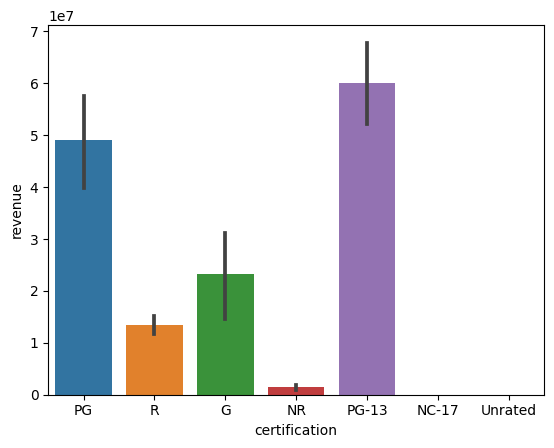

In [27]:
sns.barplot(data=df_combined, y='revenue', x='certification', ci=68);

In [28]:
df_combined.loc[df_combined['certification']=='Unrated']

,revenue,certification
486,0.0,Unrated


In [29]:
df_combined = df_combined.drop(index=483)

# The First Test

### Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

## State the null and alternative hypotheses.

Null Hypothesis: The MPAA rating does not have any effect on the revenue of a movie.

Alternate Hypothesis:The MPAA rating has a significant effect on the revenue of a movie.

alpha= 0.05

## Choose the appropriate hypothesis test

1. Numeric Quantity

2. Comparing more than 2 groups

3. One Way Anova

## Check and address the assumptions for the test

1. No significant outliers

2. Normality

3. Equal Variance

In [32]:
groups = {}
## Loop through all unique categories
for i in df_combined['certification'].unique():
    ## Get series for group and rename
    data = df_combined.loc[df_combined['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['PG', 'R', 'G', 'NR', 'PG-13', 'Unrated', 'NC-17'])

In [33]:
df_combined['certification'].value_counts()

R          1024
NR          577
PG-13       488
PG          212
G            81
NC-17        27
Unrated       1
Name: certification, dtype: int64

In [34]:
R = groups['R']
NR = groups['NR']
PG13 = groups['PG-13']
PG = groups['PG']
G = groups['G']
NC17 = groups['NC-17']

Since groups have n>15 we can ignore the assumption of normality

In [35]:
# checking outliers for each group
R_outliers = np.abs(stats.zscore(R))>3
NR_outliers = np.abs(stats.zscore(NR))>3
PG13_outliers = np.abs(stats.zscore(PG13))>3
PG_outliers = np.abs(stats.zscore(PG))>3
G_outliers = np.abs(stats.zscore(G))>3
NC17_outliers = np.abs(stats.zscore(NC17))>3

print(R_outliers.sum())
print(NR_outliers.sum())
print(PG13_outliers.sum())
print(PG_outliers.sum())
print(G_outliers.sum())
print(NC17_outliers.sum())

18
7
10
6
1
1


In [36]:
# remove the outliers from each group
R = R.loc[~R_outliers]
NR = NR.loc[~NR_outliers]
PG13 = PG13.loc[~PG13_outliers]
PG = PG.loc[~PG_outliers]
G = G.loc[~G_outliers]
NC17 = NC17.loc[~NC17_outliers]

In [37]:
result = stats.levene(R, NR, PG13, PG, G, NC17)
print(result)
print(result.pvalue<.05)

LeveneResult(statistic=43.305996396499374, pvalue=7.802353840910374e-43)
True


The p value score is less than 0.05 so I reject the null hyposthesis because the groups do not have equal variance.

I will use stats.kruskal

In [38]:
test_result = stats.kruskal(R, NR, PG13, PG, G, NC17)
print(test_result)
test_result.pvalue < .05

KruskalResult(statistic=268.5917662106319, pvalue=5.614855359911333e-56)


True

This test shows a score of less than 0.05 so we reject the null hypothesis and support the alternative hypothesis which states that the MPAA rating has a significant effect on the revenue of a movie. 

In [39]:
print(f" The averge revenue movie with R certification was {R.mean():.2f}")
print(f" The averge revenue movie with NR certification was {NR.mean():.2f}")
print(f" The averge revenue movie with PG13 certification was {PG13.mean():.2f}")
print(f" The averge revenue movie with PG certification was {PG.mean():.2f}")
print(f" The averge revenue movie with G certification was {G.mean():.2f}")
print(f" The averge revenue movie with NC17 certification was {NC17.mean():.2f}")

 The averge revenue movie with R certification was 7640230.11
 The averge revenue movie with NR certification was 338271.07
 The averge revenue movie with PG13 certification was 40613292.74
 The averge revenue movie with PG certification was 29727546.79
 The averge revenue movie with G certification was 16361706.81
 The averge revenue movie with NC17 certification was 0.00


In [46]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as revenue and the labels to the certification
values = df_combined['revenue']
labels = df_combined['certification']

In [47]:
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,NC-17,-23316447.9383,0.9322,-86636884.6288,40003988.7522,False
G,NR,-21889896.1644,0.4734,-55699411.5584,11919619.2296,False
G,PG,25728253.5551,0.3897,-11492039.254,62948546.3642,False
G,PG-13,36666869.9628,0.0263,2479937.9851,70853801.9404,True
G,R,-9835728.6987,0.9752,-42724304.4271,23052847.0297,False
G,Unrated,-23316596.0864,1.0,-310012066.7602,263378874.5874,False
NC-17,NR,1426551.7739,1.0,-54678904.133,57532007.6807,False
NC-17,PG,49044701.4934,0.1649,-9179769.7205,107269172.7072,False
NC-17,PG-13,59983317.901,0.0282,3649623.1049,116317012.6972,True
NC-17,R,13480719.2395,0.9917,-42074633.9209,69036072.4,False


## In Conclusion

The rating of PG13 has by far the highest average revenue earnings of any other certification.

# The Second Test

### Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?

## State the null and alternative hypotheses.

Null Hypothesis: Regardless of run time, all movies earn the same revenue.

Alternate Hypothesis:Movies with a run time of 2.5 hours earn more than movies with a run time of 1.5 hours.

alpha= 0.05

## Choose the appropriate hypothesis test

1. Numeric Quantity

2. Comparing 2 groups

3. 2-sample T-test: independent t-test

## Check and address the assumptions for the test

1. No significant outliers

2. Normality

3. Equal Variance

In [40]:
df_combinedhr = pd.read_csv(final_fname)
df_combinedhr.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.50,22.0,NaN
2,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.45,10.0,NaN
3,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.00,1.0,NaN
4,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,Two neighbors become intimate after discoverin...,...,14204632.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.11,2282.0,PG


In [41]:
df_combinedhr = df_combinedhr[['revenue', 'runtime']]
df_combinedhr = df_combinedhr.dropna(subset = 'runtime')
df_combinedhr.head()

,revenue,runtime
1,0.0,86.0
2,0.0,100.0
3,0.0,152.0
4,14204632.0,99.0
5,0.0,99.0


In [42]:
## filter the movies with runtime >2.5 hours and <1.5 hours
movie25 = df_combinedhr.loc[df_combinedhr['runtime']>150]
movie15 = df_combinedhr.loc[df_combinedhr['runtime']<90]

In [43]:
movie25.shape

(218, 2)

In [44]:
df_combinedhr = pd.concat([movie25, movie15], axis=0)
df_combinedhr.head()

,revenue,runtime
3,0.0,152.0
44,0.0,171.0
61,15000000.0,157.0
156,465361176.0,155.0
239,215294342.0,165.0


In [45]:
df_combinedhr['longer movie']=df_combinedhr['runtime']>150
df_combinedhr.head()

,revenue,runtime,longer movie
3,0.0,152.0,True
44,0.0,171.0,True
61,15000000.0,157.0,True
156,465361176.0,155.0,True
239,215294342.0,165.0,True


In [48]:
df_combinedhr['longer movie'].value_counts()

False    4159
True      218
Name: longer movie, dtype: int64

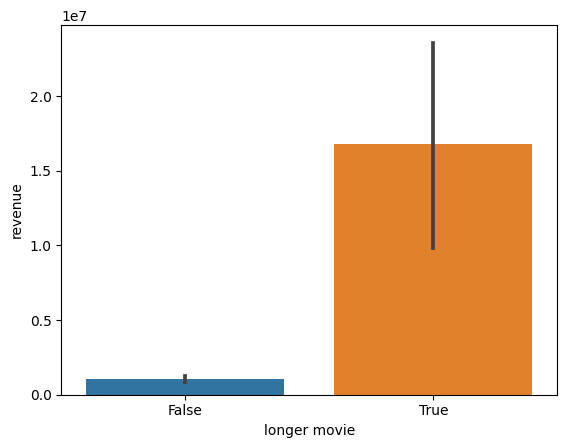

In [50]:
sns.barplot(data=df_combinedhr, x='longer movie', y='revenue', ci=68);

In [51]:
movie25_rev = movie25['revenue']
movie25_rev.head()

3              0.0
44             0.0
61      15000000.0
156    465361176.0
239    215294342.0
Name: revenue, dtype: float64

In [52]:
movie15_rev = movie15['revenue']
movie15_rev.head()

1             0.0
6             0.0
7             0.0
11        14904.0
13    224834564.0
Name: revenue, dtype: float64

Since groups have n>15 we can ignore the assumption of normality

In [53]:
movie25_out = np.abs(stats.zscore(movie25_rev))>3
movie25_out.sum()

4

In [54]:
movie25_rev = movie25_rev.loc[~movie25_out]
movie25_rev

3                0.0
44               0.0
61        15000000.0
239      215294342.0
375              0.0
            ...     
11056     28859072.0
11096            0.0
11126            0.0
11183            0.0
11192            0.0
Name: revenue, Length: 214, dtype: float64

In [55]:
movie15_out = np.abs(stats.zscore(movie15_rev))>3
movie15_out.sum()

31

In [56]:
movie15_rev = movie15_rev.loc[~movie15_out]
movie15_rev

1             0.0
6             0.0
7             0.0
11        14904.0
15            0.0
           ...   
11220         0.0
11224         0.0
11231         0.0
11235    236880.0
11238         0.0
Name: revenue, Length: 4128, dtype: float64

In [57]:
result = stats.levene(movie25_rev, movie15_rev)
print(result)
print(result.pvalue<.05)

LeveneResult(statistic=134.6560987784969, pvalue=1.1092134644805952e-30)
True


The p value score is less than 0.05 so I reject the null hyposthesis because the groups do not have equal variance.

I will use Welch's T-Test

In [58]:
test_result = stats.ttest_ind(movie25_rev, movie15_rev, equal_var=False)
print(test_result)
test_result.pvalue < .05

Ttest_indResult(statistic=2.7937912583605646, pvalue=0.005684027417121232)


True

This test shows a score of less than 0.05 so we reject the null hypothesis and support the alternative hypothesis which states movies with a run time of 2.5 hours earn more than movies with a run time of 1.5 hours.

In [59]:
print(f" The averge revenue of movies that longer than 2.5 hours was {movie25_rev.mean():.2f}")
print(f" The averge revenue of movies that shorter than 1.5 hours was {movie15_rev.mean():.2f}")

 The averge revenue of movies that longer than 2.5 hours was 4221103.21
 The averge revenue of movies that shorter than 1.5 hours was 158391.86


## Conclusion

Movies that are 2.5 hours long earn way more on average than movies that are 1.5 hours long.

# The Third Test

### Do movies released in 2020 earn less revenue than movies released in 2018?

## State the null and alternative hypotheses.

Null Hypothesis: Movies in both years earned the same in revenue.

Alternate Hypothesis:Movies that were released in 2020 earned less revenue than movies in 2018.

alpha= 0.05

## Choose the appropriate hypothesis test

1. Numeric Quantity

2. Comparing 2 groups

3. 2-sample T-test: independent t-test

## Check and address the assumptions for the test

1. No significant outliers

2. Normality

3. Equal Variance

In [60]:
df_combinedyr = pd.read_csv(final_fname)

In [61]:
df_combinedyr = df_combinedyr[['revenue', 'release_date']]
df_combinedyr = df_combinedyr.dropna(subset = 'release_date')
df_combinedyr.head()

,revenue,release_date
1,0.0,2000-09-22
2,0.0,2000-11-15
3,0.0,2000-04-14
4,14204632.0,2000-09-29
5,0.0,2000-09-02


In [62]:
import datetime as dt
df_combinedyr['release_date'] = pd.to_datetime(df_combinedyr['release_date'])
movie2018 = df_combinedyr[df_combinedyr['release_date'].dt.strftime('%Y') == '2018']
movie2018.head()

,revenue,release_date
2595,0.0,2018-11-02
2596,0.0,2018-11-06
2597,0.0,2018-05-12
2598,0.0,2018-09-21
2600,18850674.0,2018-04-19


In [63]:
movie2020 = df_combinedyr[df_combinedyr['release_date'].dt.strftime('%Y') == '2020']
movie2020.head()

,revenue,release_date
2696,0.0,2020-03-19
2729,0.0,2020-05-21
2743,0.0,2020-05-18
2758,0.0,2020-02-11
2974,0.0,2020-02-21


In [64]:
df_combinedyr = pd.concat([movie2018, movie2020], axis=0)
df_combinedyr.head()

,revenue,release_date
2595,0.0,2018-11-02
2596,0.0,2018-11-06
2597,0.0,2018-05-12
2598,0.0,2018-09-21
2600,18850674.0,2018-04-19


In [65]:
df_combinedyr['movie']=df_combinedyr['release_date'].dt.strftime('%Y') == '2018'
df_combinedyr.head()

,revenue,release_date,movie
2595,0.0,2018-11-02,True
2596,0.0,2018-11-06,True
2597,0.0,2018-05-12,True
2598,0.0,2018-09-21,True
2600,18850674.0,2018-04-19,True


In [66]:
df_combinedyr['movie'].value_counts()

True     4035
False    3353
Name: movie, dtype: int64

<AxesSubplot:xlabel='movie', ylabel='revenue'>

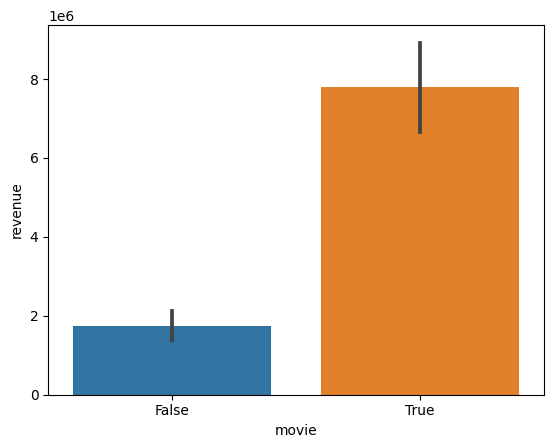

In [67]:
sns.barplot(data=df_combinedyr, x='movie', y='revenue', ci=68)

In [68]:
movie2018_rev = movie2018['revenue']
movie2018_rev.head()

2595           0.0
2596           0.0
2597           0.0
2598           0.0
2600    18850674.0
Name: revenue, dtype: float64

In [69]:
movie2020_rev = movie2020['revenue']
movie2020_rev.head()

2696    0.0
2729    0.0
2743    0.0
2758    0.0
2974    0.0
Name: revenue, dtype: float64

Since groups have n>15 we can ignore the assumption of normality

In [70]:
movie2018_out = np.abs(stats.zscore(movie2018_rev))>3
movie2018_out.sum()

38

In [71]:
movie2018_rev = movie2018_rev.loc[~movie2018_out]
movie2018_rev

2595            0.0
2596            0.0
2597            0.0
2598            0.0
2600     18850674.0
            ...    
10060           0.0
10146           0.0
10152           0.0
10341           0.0
10857           0.0
Name: revenue, Length: 3997, dtype: float64

In [72]:
movie2020_out = np.abs(stats.zscore(movie2020_rev))>3
movie2020_out.sum()

18

In [73]:
movie2020_rev = movie2020_rev.loc[~movie2020_out]
movie2020_rev

2696     0.0
2729     0.0
2743     0.0
2758     0.0
2974     0.0
        ... 
11241    0.0
11242    0.0
11243    0.0
11244    0.0
11245    0.0
Name: revenue, Length: 3335, dtype: float64

In [74]:
result = stats.levene(movie2018_rev, movie2020_rev)
print(result)
print(result.pvalue<.05)

LeveneResult(statistic=51.413413926155506, pvalue=8.213463550379323e-13)
True


The p value score is less than 0.05 so I reject the null hyposthesis because the groups do not have equal variance.

I will use Welch's T-Test

In [77]:
result = stats.ttest_ind(movie2018_rev, movie2020_rev, equal_var=False)
print(result)
result.pvalue < .05

Ttest_indResult(statistic=7.763762349287445, pvalue=1.0090038788948561e-14)


True

This test shows a score of less than 0.05 so we reject the null hypothesis and support the alternative hypothesis which states movies that were released in 2020 earned less revenue than movies in 2018.

In [78]:
print(f" The averge revenue of movies released in 2018 earned was {movie2018_rev.mean():.2f}")
print(f" The averge revenue of movies released in 2020 earned was {movie2020_rev.mean():.2f}")

 The averge revenue of movies released in 2018 earned was 2304009.61
 The averge revenue of movies released in 2020 earned was 494097.60


## Conclusion

Movies released in 2018 were more profitable than movies released in 2020.